# Facial Recognition using Siamese Network

Facial recognition using a Siamese network involves training a neural network to learn a similarity metric
between two images of faces. The Siamese network architecture consists of two identical subnetworks that
share weights. The two subnetworks take as input two images of faces and extract features from them.
The features are then compared using a distance metric, such as Euclidean distance or cosine similarity,
to produce a similarity score between the two images.

The Siamese network is trained using pairs of images, where one image is from the same person and
the other is from a different person. The network is trained to minimize the distance between the features
of the same person's images and maximize the distance between the features of different persons' images.

During testing, the Siamese network takes as input a pair of images and outputs a similarity score.
If the similarity score is above a certain threshold, the two images are classified as belonging to the same person;
otherwise, they are classified as belonging to different persons.

Siamese networks have been shown to be effective for facial recognition tasks, especially in scenarios where the
dataset is small and the number of classes is limited. However, they may not perform as well as other deep learning models,
such as convolutional neural networks, in scenarios with larger datasets and more classes.

## Importing Libraries and downloading olivetti dataset

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
import random

The Olivetti dataset is a widely used face image dataset for testing and developing face recognition algorithms.
The dataset contains a collection of grayscale images of faces from 40 different subjects, with 10 images per subject. 

In [41]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils import shuffle
import numpy as np

# Download Olivetti faces dataset
olivetti = fetch_olivetti_faces()
images = olivetti.images
targets = olivetti.target

In [87]:
targets

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

Random names given to each subject

In [88]:
target_names = [
    "Liam",
"Noah",
"Ethan",
"Oliver",
"Mason",
"Elijah",
"Logan",
"Aiden",
"James",
"Benjamin",
"Jackson",
"Lucas",
"Jacob",
"William",
"Daniel",
"Michael",
"Alexander",
"Samuel",
"Matthew",
"Joseph",
"Caleb",
"Sebastian",
"Gabriel",
"Owen",
"Connor",
"Isaac",
"Nicholas",
"Luke",
"David",
"Ryan",
"Nathan",
"Henry",
"Andrew",
"Cameron",
"Eli",
"Christian",
"Anthony",
"Jonathan",
"Grayson",
"Robert"
]

In [42]:
#utility function to get pairs of positive and negative matching face pairs
def gen_images_and_labels(images,labels):
    unique_labels = np.unique(y)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(y) if
                                       label == curr_label])
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images):
        pos_indices = label_wise_indices.get(labels[index])
        pos_image = images[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels != labels[index])
        neg_image = images[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
        
    return np.array(pair_images), np.array(pair_labels)

In [43]:
images_dataset, labels_dataset = gen_images_and_labels(images, targets)
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

## Visulization

In [44]:
def visualize(image_pairs, labels, n = 5, title = "Image Pair Examples"):

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    plt.title(title)
    axs = fig.subplots(n, 2)
    for i in range(n):
        show(axs[i, 0], image_pairs[i][0])
        show(axs[i, 1], image_pairs[i][1])

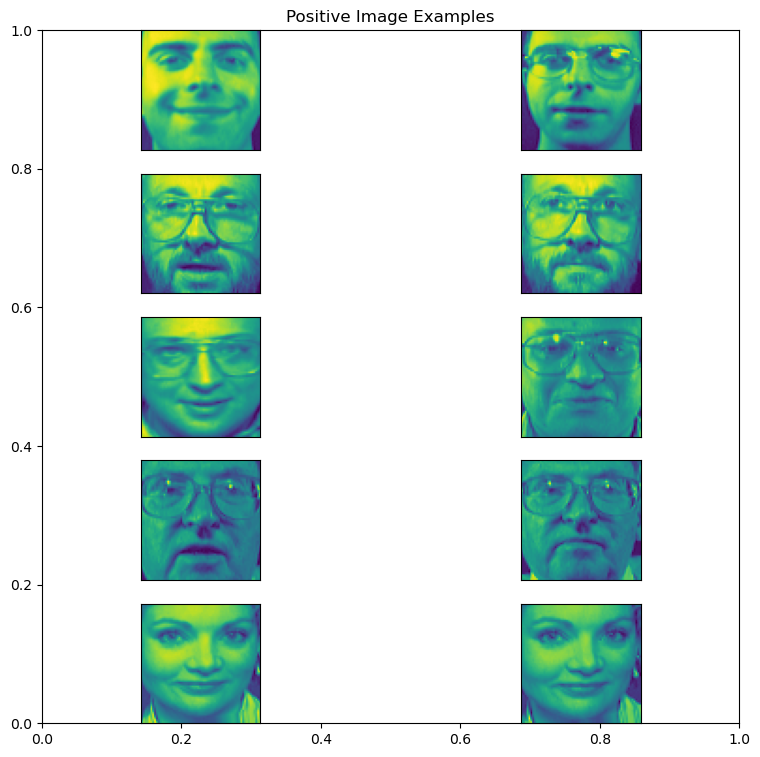

In [45]:
n = 5
indices = np.where(labels_dataset == 1)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Positive Image Examples")

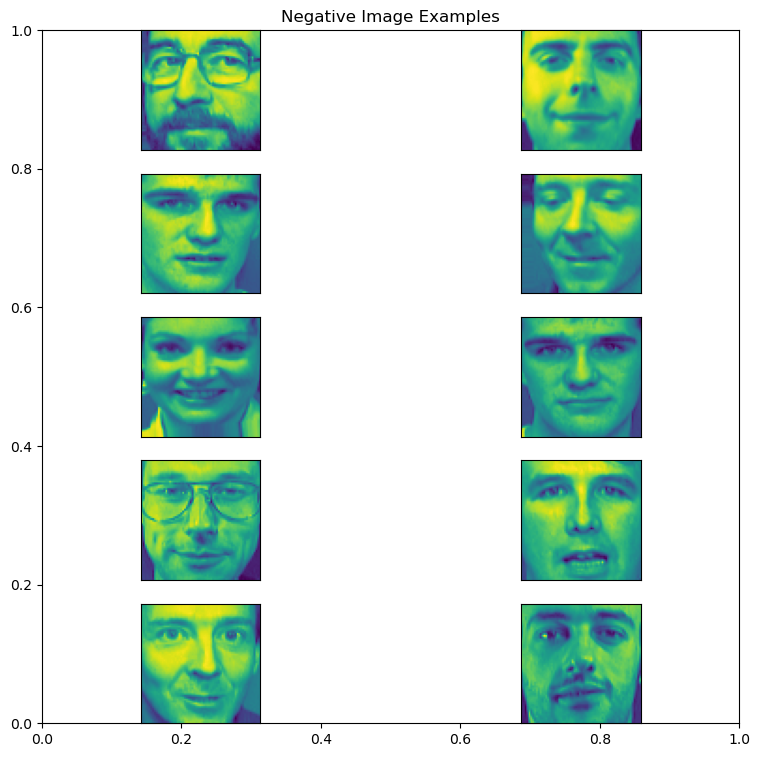

In [46]:
n = 5
indices = np.where(labels_dataset == 0)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Negative Image Examples")

## Building Siamese Network

In [47]:
# embedding model to get feature vector of each image
inputs = layers.Input((64,64,1))

x = layers.Conv2D(64, (10, 10), padding = 'same', activation = 'relu')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (7, 7), padding = 'same', activation = 'relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (4, 4), padding = 'same', activation = 'relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, (4, 4), padding = 'same', activation = 'relu')(x)
fc_output = layers.Flatten()(x)
fc_output = layers.Dense(4096, activation = 'relu')(fc_output)
outputs = layers.Dense(1024, activation = 'sigmoid')(fc_output)

embedding = Model(inputs, outputs, name = "Embedding")

In [48]:
def contrastive_loss(y, preds, margin = 1):
    y = tf.cast(y, preds.dtype)
    sq_preds = K.square(preds)
    sq_margin = K.square(K.maximum((margin - preds, 0)))
    loss = K.mean(y * sq_preds + (1-y) * sq_margin)
    return loss

In [49]:
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, anchor, compare):
        sum_sq = K.sum(K.square(anchor - compare), axis = 1, keepdims = True)
        return K.sqrt(K.maximum(sum_sq, K.epsilon()))

In [50]:
target_shape = images[0].shape
anchor_input = layers.Input(name = "anchor", shape = target_shape + (1,))
compare_input = layers.Input(name = "compare", shape = target_shape + (1,))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(compare_input))

outputs = layers.Dense(1, activation = "sigmoid")(distances)

siamese_model = Model(
    inputs = [anchor_input, compare_input], outputs = outputs
)

Training

In [51]:
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = siamese_model.fit([images_dataset[:, 0, :], images_dataset[:, 1, :]], labels_dataset,
                            epochs=150, validation_split = 0.2, batch_size = 64)

Epoch 1/150
10/10 [==============================] - 16s 1s/step - loss: 0.6645 - accuracy: 0.5063 - val_loss: 0.6199 - val_accuracy: 0.5562
Epoch 2/150
10/10 [==============================] - 14s 1s/step - loss: 0.6321 - accuracy: 0.5063 - val_loss: 0.5962 - val_accuracy: 0.5375
Epoch 3/150
10/10 [==============================] - 14s 1s/step - loss: 0.6365 - accuracy: 0.5063 - val_loss: 0.5931 - val_accuracy: 0.5437
Epoch 4/150
10/10 [==============================] - 14s 1s/step - loss: 0.6255 - accuracy: 0.5063 - val_loss: 0.6001 - val_accuracy: 0.5375
Epoch 5/150
10/10 [==============================] - 14s 1s/step - loss: 0.6128 - accuracy: 0.5063 - val_loss: 0.5841 - val_accuracy: 0.5375
Epoch 6/150
10/10 [==============================] - 14s 1s/step - loss: 0.6161 - accuracy: 0.5250 - val_loss: 0.5998 - val_accuracy: 0.5813
Epoch 7/150
10/10 [==============================] - 14s 1s/step - loss: 0.6020 - accuracy: 0.5188 - val_loss: 0.5818 - val_accuracy: 0.5437
Epoch 8/150
1

Epoch 59/150
10/10 [==============================] - 14s 1s/step - loss: 0.3948 - accuracy: 0.8406 - val_loss: 0.5493 - val_accuracy: 0.8062
Epoch 60/150
10/10 [==============================] - 14s 1s/step - loss: 0.3980 - accuracy: 0.8438 - val_loss: 0.4850 - val_accuracy: 0.8687
Epoch 61/150
10/10 [==============================] - 14s 1s/step - loss: 0.3879 - accuracy: 0.8781 - val_loss: 0.4768 - val_accuracy: 0.8875
Epoch 62/150
10/10 [==============================] - 14s 1s/step - loss: 0.3781 - accuracy: 0.8734 - val_loss: 0.3945 - val_accuracy: 0.8625
Epoch 63/150
10/10 [==============================] - 14s 1s/step - loss: 0.3838 - accuracy: 0.8797 - val_loss: 0.4426 - val_accuracy: 0.9125
Epoch 64/150
10/10 [==============================] - 14s 1s/step - loss: 0.3815 - accuracy: 0.8609 - val_loss: 0.5566 - val_accuracy: 0.7875
Epoch 65/150
10/10 [==============================] - 15s 1s/step - loss: 0.3719 - accuracy: 0.9016 - val_loss: 0.4713 - val_accuracy: 0.8625
Epoch 

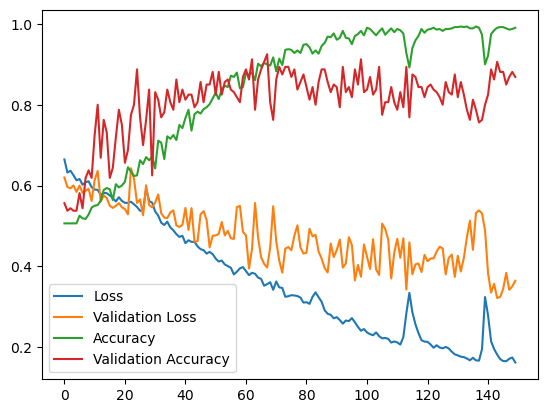

In [52]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"])


## Testing

In [99]:
no = int(len(targets)/10)

In [85]:
test_index = random.sample(range(10), 1)[0]
test_image = images[test_index]

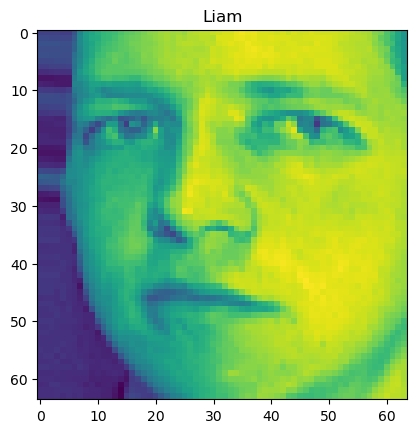

In [92]:
plt.title(target_names[int(test_index/10)])
plt.imshow(test_image)

In [130]:
def vis_faces(images, n):
    def show(ax, image, i):
        ax.imshow(image)
        ax.set_title(target_names[i])
        ax.axis('off')
    
    fig = plt.figure(figsize=(100,100))
    axs = fig.subplots(n,1)
    for i in range(n):
        show(axs[i], images[i], i)

In [131]:
compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = images[index]
    compare_images.append(image)

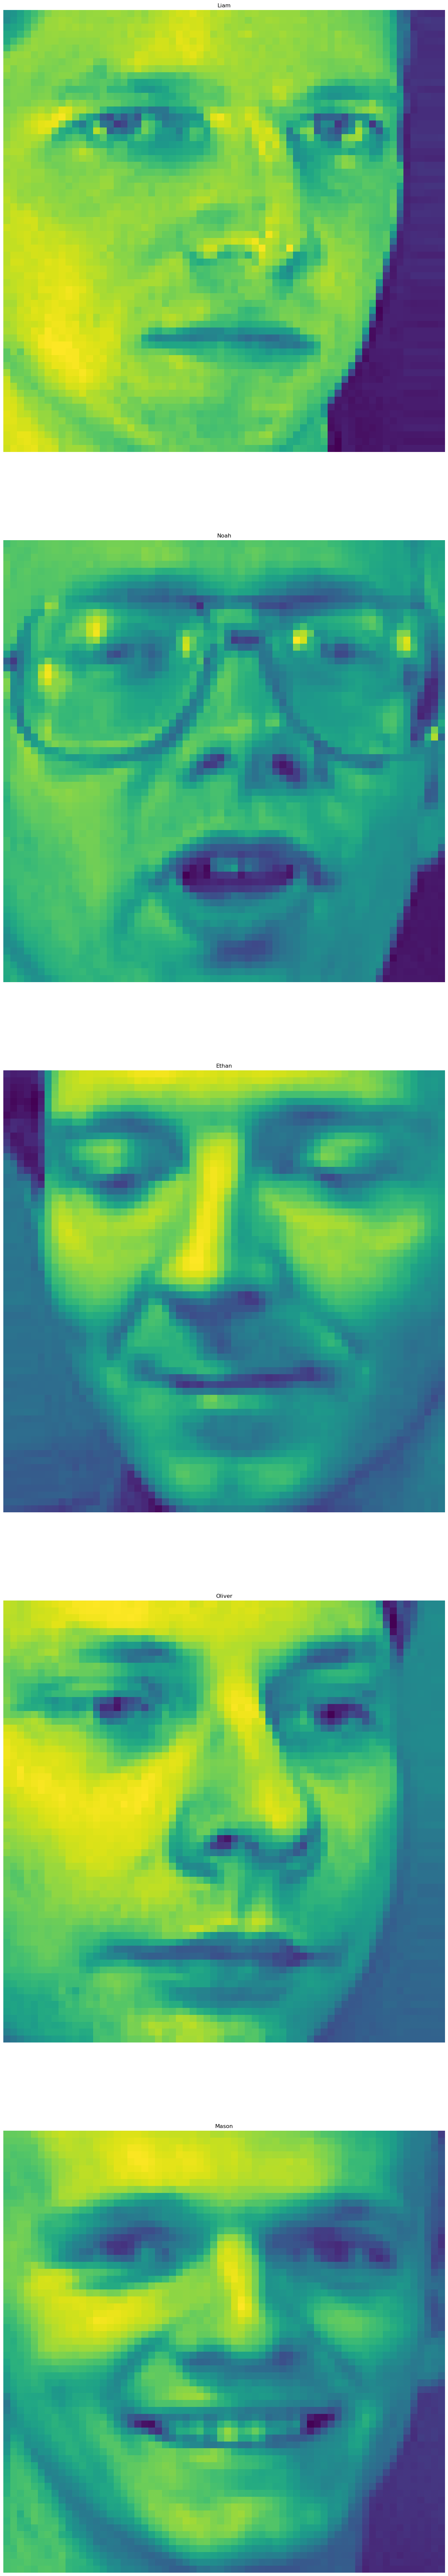

In [132]:
vis_faces(compare_images, 5)

In [133]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))
    
image_pairs = np.array(image_pairs)

In [134]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

1/1 [==============================] - 0s 80ms/step


In [135]:
print(score)

[[0.37867433]
 [0.00812163]
 [0.03144319]
 [0.01436352]
 [0.00635815]]


In [137]:
target_names[np.argmax(score)]

'Liam'